In [3]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from skimage import exposure

import mlflow # model runs
mlflow.set_tracking_uri("sqlite:///mlflow.db") # Use sqlite for more efficient storage
# https://www.mlflow.org/docs/latest/python_api/mlflow.tensorflow.html#mlflow.tensorflow.autolog
mlflow.tensorflow.autolog()

BATCH_SIZE = 128
EQUALIZE = False

mixed_precision.set_global_policy('mixed_float16')

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/mnt/data/IVF/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    if len(files_in_folder) == 0:
        print(f"{folder} is empty!")
        os.rmdir(BASE_DIR / folder)
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Empty         8766
Compacting    4781
Blast         4148
2pn           3064
4 Cell        2418
2 Cell        2392
Syngamy       1958
8 Cell        1486
9+ Cell       1379
6-7 Cell      1352
3 Cell         684
5 Cell         599
Name: class, dtype: int64

<AxesSubplot:>

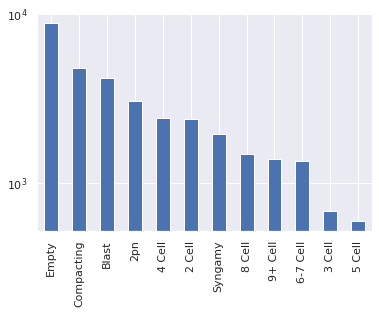

In [4]:
df["class"].value_counts().plot.bar(logy=True)

In [5]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: "_".join(s.split("/")[-1].split("_")[:2])).value_counts()

M0831_S00493    2320
M776_S0192      2284
M0831_S00635    2049
M0776_S00512    1952
M3171_S00629    1918
M0776_S00437    1851
M776_S0087      1559
M0776_S00635    1325
M0776_S00534    1232
M0831_S00479    1194
M0776_S00761    1138
M831_S0127       881
M0776_S00488     788
M0776_S00470     784
M0831_S00534     717
M0831_S00470     701
M0776_S00322     544
M0776_S00447     508
M0800_S00426     287
M3169_S00668     123
M3169_S00737      76
M0776_S00737      21
M0831_S00659       9
Name: filename, dtype: int64

In [6]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

           class  time_since_fert
1507         2pn             1061
1643     Syngamy             1464
974       2 Cell             1574
267       3 Cell             2315
308       4 Cell             2395
32        5 Cell             3045
72      6-7 Cell             3125
604       8 Cell             3265
241   Compacting             3375
688        Blast             6090
7260       Empty             7036


In [7]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6-7 Cell',
 '8 Cell',
 'Compacting',
 'Blast',
 'Empty']

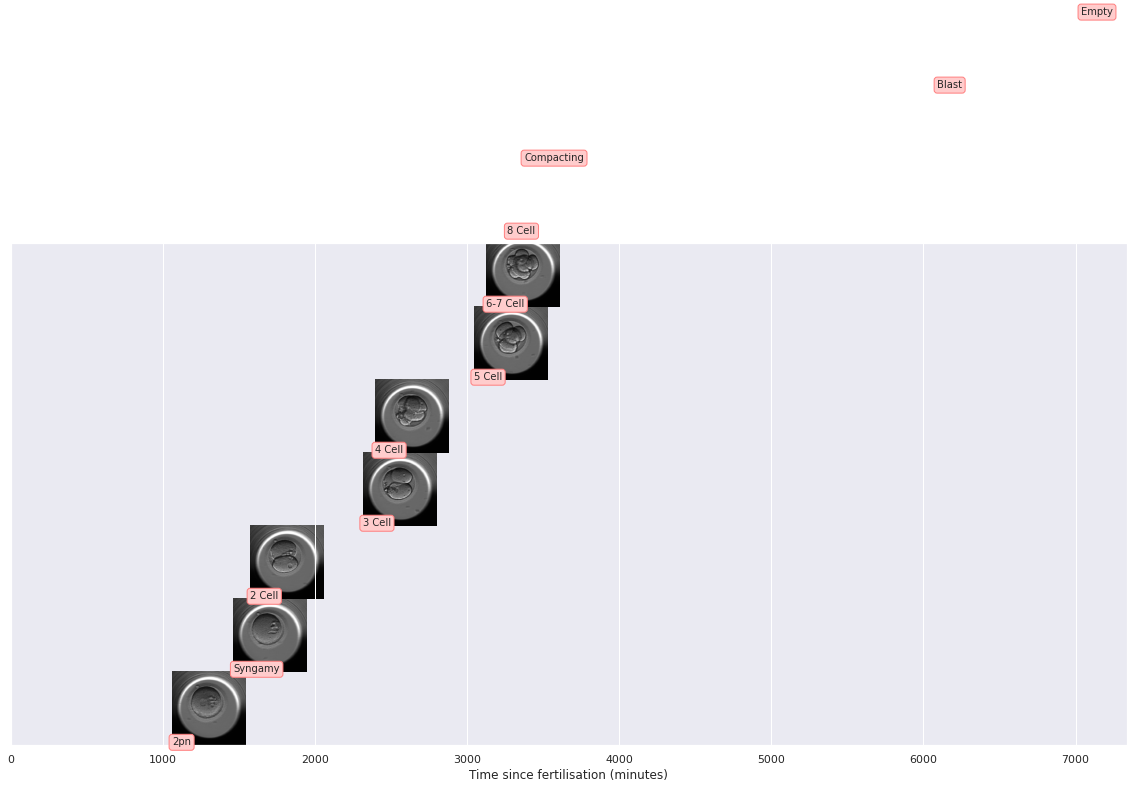

In [8]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(480,480))
    c_index = classes.index(row["class"]) * 480
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+480, c_index, c_index+480])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

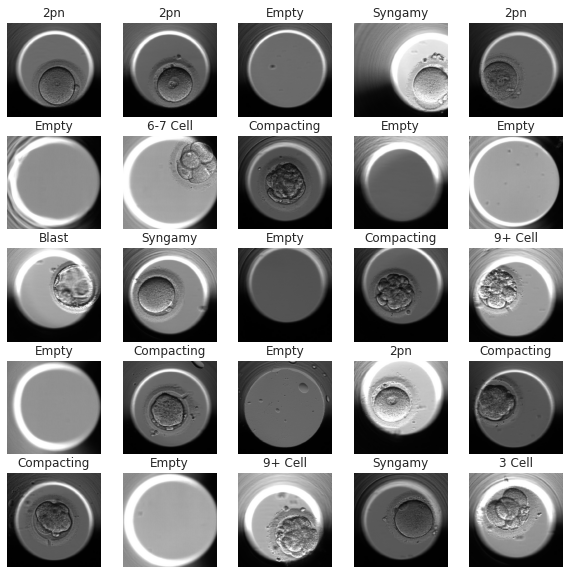

In [9]:
plt.figure(figsize=(10, 10))
sample = df.sample(25)
for i, (idx, row) in enumerate(sample.iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    img = keras.utils.load_img(row.filename, target_size=(480,480))
    if EQUALIZE:
        img = tfa.image.equalize(img)
    plt.imshow(img)
    plt.title(row["class"])
    plt.axis("off")

In [10]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (480,480),
    batch_size = BATCH_SIZE, #// 4, # / 4 here, because the augmentations will * 4
    label_mode = 'categorical',
    shuffle = False
)
if EQUALIZE:
    train_cache = train.map(lambda x, y: (tfa.image.equalize(x), y)).prefetch(tf.data.AUTOTUNE)
else:
    train_cache = train.prefetch(tf.data.AUTOTUNE)

Found 33027 files belonging to 12 classes.


2022-07-11 15:34:33.579887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 15:34:33.580885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:34:33.581137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:34:33.581268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [11]:
len(train_cache)

259

In [12]:
#list(tqdm(train_cache)); # load it all into RAM

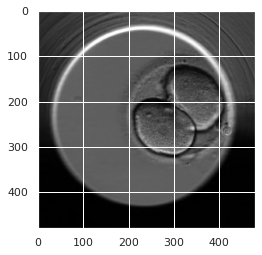

In [13]:
x, y = next(iter(train_cache))
plt.imshow(x.numpy()[100].astype("uint8"))

In [14]:
class AugmentationGenerator(tf.keras.utils.Sequence):
    def __getitem__(self, idx):
        x, y = next(iter(train_cache.skip(idx).take(1)))
        x = np.vstack([
            x,
            np.flip(x, axis=1),
            np.flip(x, axis=2),
            np.flip(np.flip(x, axis=1), axis=2),
        ])
        y = np.vstack([
            y, y, y, y
        ])
        return x, y
    def __len__(self):
        return len(train_cache)

x, y = AugmentationGenerator().__getitem__(0)
print(x.shape, y.shape)

(512, 480, 480, 3) (512, 12)


In [15]:
len(AugmentationGenerator())

259

In [16]:
classes = train.class_names
print(len(classes))
classes

12


['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6-7 Cell',
 '8 Cell',
 '9+ Cell',
 'Blast',
 'Compacting',
 'Empty',
 'Syngamy']

In [17]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(480,480,3)),
    keras.applications.EfficientNetV2L(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg",
        include_preprocessing=False
    )
])
#base_model.save(f"models/xception.h5")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 480, 480, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 1280)             117746848 
 l)                                                              
                                                                 
Total params: 117,746,848
Trainable params: 117,234,272
Non-trainable params: 512,576
_________________________________________________________________


In [18]:
cachefile = f"extracted_features{'_eq' if EQUALIZE else ''}.npy"
print(cachefile)
try:
    extracted_features = np.load(cachefile)
    assert len(extracted_features) == len(train.file_paths)*4
except Exception as e:
    print(e)
    extracted_features = base_model.predict(AugmentationGenerator())
    np.save(cachefile, extracted_features)

extracted_features.npy
[Errno 2] No such file or directory: 'extracted_features.npy'


2022-07-11 15:35:44.936285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-07-11 15:35:45.862619: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


231/259 [=========================>....] - ETA: 5:17

2022-07-11 16:19:46.559107: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB (rounded to 3774873600)requested by op sequential/efficientnetv2-l/block2b_expand_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-11 16:19:46.559235: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-07-11 16:19:46.559249: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 394, Chunks in use: 394. 98.5KiB allocated for chunks. 98.5KiB in use in bin. 25.3KiB client-requested in use in bin.
2022-07-11 16:19:46.559266: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 106, Chunks in use: 106. 64.0KiB allocated for chunks. 64.0KiB in use in bin. 55.4KiB cl

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/efficientnetv2-l/block2b_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_111867/2273700900.py", line 8, in <cell line: 3>
      extracted_features = base_model.predict(AugmentationGenerator())
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py", line 584, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/efficientnetv2-l/block2b_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[512,120,120,256] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/efficientnetv2-l/block2b_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_34858]

In [17]:
del train_cache

In [ ]:
extracted_features.shape

(97532, 1280)

In [ ]:
y = np.vstack([np.vstack([y,y,y,y]) for x,y in train])
y.shape

(97532, 12)

In [ ]:
aug_paths = []
for i in range(len(train)):
    batch_paths = train.file_paths[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    aug_paths.extend(batch_paths * 4)
aug_paths = pd.Series(aug_paths)
display(aug_paths)

0        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00437_W1_F0_1633.jpg
1        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00437_W1_F0_1653.jpg
2        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00437_W1_F0_1673.jpg
3        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00437_W1_F0_1694.jpg
4        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00437_W1_F0_1714.jpg
                                       ...                               
97527     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1555.jpg
97528     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1585.jpg
97529     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1605.jpg
97530     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1625.jpg
97531     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1645.jpg
Length: 97532, dtype: object

In [ ]:
fert_minutes = aug_paths.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)/9978
fert_minutes

0        0.163660
1        0.165664
2        0.167669
3        0.169774
4        0.171778
           ...   
97527    0.155843
97528    0.158849
97529    0.160854
97530    0.162858
97531    0.164863
Length: 97532, dtype: float64

In [ ]:
extracted_features_with_fert = np.hstack([extracted_features, fert_minutes.to_numpy()[:, None]])
extracted_features_with_fert.shape

(97532, 1281)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_slide = "S0047"
test_idx = aug_paths.str.contains(test_slide)
x_train = extracted_features_with_fert[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features_with_fert[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((80004, 1281), (80004, 12), (17528, 1281), (17528, 12))

In [65]:
class_weights = class_weight.compute_class_weight("balanced", classes = np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights = class_weights.round(6) # This is necessary if using mlflow, as it can go beyond the 250 character limit otherwise
class_weights = dict(enumerate(class_weights))
{k:v for k,v in zip(classes, class_weights.values())}

{'2 Cell': 1.167768,
 '2pn': 0.873567,
 '3 Cell': 4.268732,
 '4 Cell': 1.218906,
 '5 Cell': 4.78098,
 '6-7 Cell': 2.132127,
 '8 Cell': 2.514748,
 '9+ Cell': 2.861854,
 'Blast': 0.79683,
 'Compacting': 0.569963,
 'Empty': 0.266761,
 'Syngamy': 1.314306}

In [66]:
# Hyperparameter search
search = False
if search:
    def build_model(hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(x_train.shape[1])))

        for i in range(hp.Int("n_layers", 1, 4)):
            model.add(keras.layers.Dense(
                hp.Int(f"dense_units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice(f"dense_activation_{i}", values=["relu", "sigmoid"], default="relu")
            ))
            model.add(keras.layers.Dropout(hp.Float(f"dropout_{i}", min_value=.1, max_value=.5, step=.1)))

        model.add(keras.layers.Dense(len(classes), activation="softmax"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float(
                "learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
            )),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=[keras.metrics.CategoricalAccuracy()],
        )
        return model

    tuner = RandomSearch(
        build_model,
        objective="val_categorical_accuracy",
        max_trials=80,
    )
    tuner.search_space_summary()
    tuner.search(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        epochs=500,
        verbose=0,
        class_weight=class_weights,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
            tfa.callbacks.TQDMProgressBar()
        ]
    )
    print(tuner.get_best_hyperparameters()[0].values)
    print(tuner.get_best_models()[0].summary())

In [67]:
%%time
with mlflow.start_run():
    mlflow.log_params({
        "classes": classes,
        "equalized": EQUALIZE,
        "test slide": test_slide,
        "x_train_shape": x_train.shape,
        "y_train_shape": y_train.shape,
        "x_test_shape": x_test.shape,
        "y_test_shape": y_test.shape
    })

    model = keras.Sequential([
        keras.layers.Input(shape=(x_train.shape[1])),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(len(classes), activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
            .001,
            decay_steps=1e4,
            decay_rate=0.96,
            staircase=True
        )),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    print(model.summary())
    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        epochs=500,
                        verbose=0,
                        class_weight=class_weights,
                        callbacks=[
                            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=100, verbose=1),
                            tfa.callbacks.TQDMProgressBar()
                        ])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               656384    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 12)                6156      
                                                                 
Total params: 925,196
Trainable params: 925,196
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/626           ETA: ?s - 

Epoch 2/500


0/626           ETA: ?s - 

Epoch 3/500


0/626           ETA: ?s - 

Epoch 4/500


0/626           ETA: ?s - 

Epoch 5/500


0/626           ETA: ?s - 

Epoch 6/500


0/626           ETA: ?s - 

Epoch 7/500


0/626           ETA: ?s - 

Epoch 8/500


0/626           ETA: ?s - 

Epoch 9/500


0/626           ETA: ?s - 

Epoch 10/500


0/626           ETA: ?s - 

Epoch 11/500


0/626           ETA: ?s - 

Epoch 12/500


0/626           ETA: ?s - 

Epoch 13/500


0/626           ETA: ?s - 

Epoch 14/500


0/626           ETA: ?s - 

Epoch 15/500


0/626           ETA: ?s - 

Epoch 16/500


0/626           ETA: ?s - 

Epoch 17/500


0/626           ETA: ?s - 

Epoch 18/500


0/626           ETA: ?s - 

Epoch 19/500


0/626           ETA: ?s - 

Epoch 20/500


0/626           ETA: ?s - 

Epoch 21/500


0/626           ETA: ?s - 

Epoch 22/500


0/626           ETA: ?s - 

Epoch 23/500


0/626           ETA: ?s - 

Epoch 24/500


0/626           ETA: ?s - 

Epoch 25/500


0/626           ETA: ?s - 

Epoch 26/500


0/626           ETA: ?s - 

Epoch 27/500


0/626           ETA: ?s - 

Epoch 28/500


0/626           ETA: ?s - 

Epoch 29/500


0/626           ETA: ?s - 

Epoch 30/500


0/626           ETA: ?s - 

Epoch 31/500


0/626           ETA: ?s - 

Epoch 32/500


0/626           ETA: ?s - 

Epoch 33/500


0/626           ETA: ?s - 

Epoch 34/500


0/626           ETA: ?s - 

Epoch 35/500


0/626           ETA: ?s - 

Epoch 36/500


0/626           ETA: ?s - 

Epoch 37/500


0/626           ETA: ?s - 

Epoch 38/500


0/626           ETA: ?s - 

Epoch 39/500


0/626           ETA: ?s - 

Epoch 40/500


0/626           ETA: ?s - 

Epoch 41/500


0/626           ETA: ?s - 

Epoch 42/500


0/626           ETA: ?s - 

Epoch 43/500


0/626           ETA: ?s - 

Epoch 44/500


0/626           ETA: ?s - 

Epoch 45/500


0/626           ETA: ?s - 

Epoch 46/500


0/626           ETA: ?s - 

Epoch 47/500


0/626           ETA: ?s - 

Epoch 48/500


0/626           ETA: ?s - 

Epoch 49/500


0/626           ETA: ?s - 

Epoch 50/500


0/626           ETA: ?s - 

Epoch 51/500


0/626           ETA: ?s - 

Epoch 51: early stopping
INFO:tensorflow:Assets written to: /tmp/tmpq0s0kll4/model/data/model/assets
CPU times: user 5min 6s, sys: 57.2 s, total: 6min 3s
Wall time: 3min 36s


In [27]:
model.save(f"models/efnetv2_{len(classes)}_class.h5")

In [28]:
pd.Series(classes).to_csv(f"models/{len(classes)}_class.h5_classes.txt", index=False, header=False)

<AxesSubplot:>

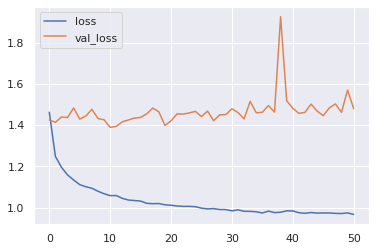

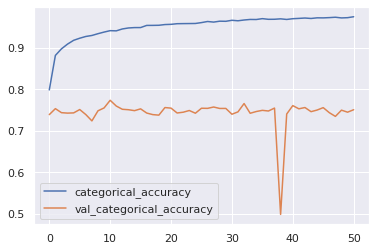

In [68]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [69]:
y_pred = model.predict(x_test)

548/548 [==============================] - 1s 2ms/step


In [83]:
validation_df = pd.DataFrame()
validation_df["filepaths"] = aug_paths[test_idx].to_list()
aug_pred = pd.concat([validation_df, pd.DataFrame(y_pred, columns=classes)], axis="columns").groupby(
    "filepaths").sum().to_numpy()
display(aug_pred)
validation_df["true"] = y_test.argmax(axis=1)
aug_true = validation_df.groupby("filepaths").head(1)["true"]
display(aug_true)

array([[3.318  , 0.07654, 0.0637 , ..., 0.05942, 0.05493, 0.0858 ],
       [3.32   , 0.0802 , 0.07056, ..., 0.0565 , 0.05444, 0.0897 ],
       [3.32   , 0.0654 , 0.0647 , ..., 0.05676, 0.05524, 0.0808 ],
       ...,
       [0.1207 , 0.3933 , 0.0631 , ..., 0.0685 , 0.0759 , 2.852  ],
       [0.2416 , 0.2308 , 0.0658 , ..., 0.0784 , 0.1012 , 2.764  ],
       [0.658  , 0.871  , 0.0636 , ..., 0.10547, 0.149  , 1.491  ]],
      dtype=float16)

0         0
1         0
2         0
3         0
4         0
         ..
17337    11
17338    11
17339    11
17340    11
17341    11
Name: true, Length: 4382, dtype: int64

In [84]:
pd.Series(aug_pred.argmax(axis=1)).value_counts()

10    1704
1      686
9      400
11     346
0      334
3      196
7      185
6      185
8      143
5      107
2       50
4       46
dtype: int64

In [85]:
predicted_codes = aug_pred.argmax(axis=1)
confidence = aug_pred.max(axis=1)
pd.Series(confidence).describe()

count    4382.000000
mean        2.775391
std         0.609863
min         0.670410
25%         2.472656
50%         3.085938
75%         3.187500
max         3.537109
dtype: float64

In [98]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import f1_score

top_k_accuracy_score(aug_true,aug_pred,k=2)


0.8797352806937472

In [95]:

f1_score(aug_true,predicted_codes,average="weighted")


0.7454391687541021

In [87]:
validation_df = pd.DataFrame()
validation_df["true_class"] = aug_true
validation_df["predicted_class"] = predicted_codes
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,0,0,3.318359
1,0,0,3.320312
2,0,0,3.320312
3,0,0,3.335938
4,0,0,3.343750
...,...,...,...
17337,11,11,2.871094
17338,11,11,2.126953
17339,11,11,2.851562
17340,11,11,2.763672


In [89]:
validation_df.groupby("predicted_class").confidence.median()/4

predicted_class
0     0.660156
1     0.808594
2     0.450684
3     0.486328
4     0.432129
5     0.455078
6     0.561523
7     0.489014
8     0.773926
9     0.671875
10    0.784180
11    0.770020
Name: confidence, dtype: float16

In [36]:
validation_df.to_csv("validation_predictions.csv", index=False)

              precision    recall  f1-score   support

           0       0.49      0.86      0.62       191
           1       0.74      0.88      0.80       574
           2       0.12      0.05      0.07       119
           3       0.63      0.50      0.56       249
           4       0.20      0.06      0.09       155
           5       0.38      0.25      0.31       161
           6       0.38      0.84      0.53        85
           7       0.55      0.42      0.48       244
           8       0.91      0.84      0.88       154
           9       0.47      0.66      0.55       284
          10       1.00      1.00      1.00      1703
          11       0.81      0.61      0.69       463

    accuracy                           0.76      4382
   macro avg       0.56      0.58      0.55      4382
weighted avg       0.75      0.76      0.75      4382

[ 0.   0.   0.   0.   0.   0.   1.   4.  13.8 62.5]


Text(66.5, 0.5, 'True')

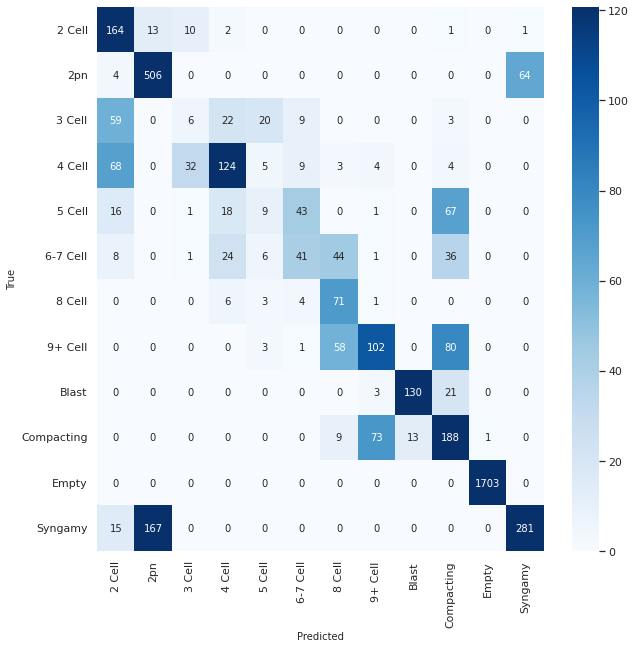

In [90]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
confusion = confusion_matrix(validation_df["true_class"], validation_df["predicted_class"])
print(np.quantile(confusion, np.arange(0, 1, .1)))
plt.figure(figsize=(10,10))
s = sns.heatmap(
    confusion,
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes,
    vmax=np.quantile(confusion, .95)
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)